In [ ]:
!pip install biopython
!pip install dmslogo
!pip install fastcluster
!pip install wordcloud
!pip install bottleneck
!pip install adjustText
!pip install hdbscan

from google.colab import output
output.clear()

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
from functools import partial
import ast
import dmslogo

import arviz as az
import seaborn as sns
import scipy.cluster.hierarchy as hierarchy
import scipy.sparse as sparse
import scipy.stats as stats
from scipy.ndimage import gaussian_filter1d
import warnings

import Bio
from Bio import motifs
from operator import itemgetter

import networkx as nx
from networkx.algorithms import bipartite

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)

from tqdm.auto import tqdm
tqdm.pandas()

pd.set_option('display.max_columns', None)

if torch.cuda.is_available():
    use_cuda = True
    torch.backends.cudnn.benchmark = True
    print(f'GPU available: {torch.cuda.get_device_name(0)} ({torch.cuda.device_count()} count)')
else:
    print('No GPU available')

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import pickle
import fastcluster
from scipy.cluster.hierarchy import dendrogram, leaves_list
from wordcloud import WordCloud, STOPWORDS
from matplotlib.colors import LinearSegmentedColormap

from adjustText import adjust_text
import matplotlib.patheffects as PathEffects

import hdbscan

No GPU available


In [ ]:
class constants():
    def __init__(self):
        self.STANDARD_NT = ['A','C','G','T']
        self.DNA_COMPLEMENTS = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
constants = constants()

class utils():
    @staticmethod
    def pad_pssm(row, pad_len=24, column_name='pssm'):
        padded_pssm = np.zeros((4, pad_len))
        padded_pssm[:, 0:row['length']] = row[column_name]
        return padded_pssm

    @staticmethod
    def pad_seq_tensor(seq_tensor, pad_len=217, dim=-1):
        assert seq_tensor.shape[dim] <= pad_len
        padded_tensor = torch.zeros((4, pad_len))
        padded_tensor[:, 0:seq_tensor.shape[dim]] = seq_tensor
        return padded_tensor

    @staticmethod
    def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
        seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor

    @staticmethod
    def row_dna2tensor(row, in_column_name='padded_seq' , vocab=['A', 'C', 'G', 'T']):
        sequence_str = row[in_column_name]
        seq_idxs = torch.tensor([vocab.index(letter) for letter in sequence_str])
        sequence_tensor = F.one_hot(seq_idxs, num_classes=4).transpose(1,0)
        return sequence_tensor.type(torch.float32)

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

    @staticmethod
    def reverse_complement_onehot(x, nt_order=constants.STANDARD_NT,
                              complements=constants.DNA_COMPLEMENTS):
        comp_alphabet = [ complements[nt] for nt in nt_order ]
        permutation = [ nt_order.index(nt) for nt in comp_alphabet ]
        return torch.flip(x[..., permutation, :], dims=[-1])

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

def counts_to_ppm(in_tensor):
    motif = in_tensor.div( in_tensor.sum(0) )
    return motif

def ppm_to_pwm(in_tensor,bkg=[0.25,0.25,0.25,0.25]):
    motif = in_tensor.div(torch.tensor(bkg).unsqueeze(1)).log2()
    return motif

def ppm_to_U(in_tensor):
    return (in_tensor.log2() * in_tensor).sum(0).mul(-1.)

def ppm_to_IC(in_tensor):
    return in_tensor * ppm_to_U( in_tensor ).mul(-1.).add(2.)

def tensor_to_pandas(in_tensor, tokens=constants.STANDARD_NT, colors=['green','orange','red','blue']):
    data = []
    my_array = in_tensor.cpu().numpy()
    for nt, score_vec,color in zip(tokens,[ sub_a for sub_a in my_array ],colors):
         _ = [ data.append([j,nt,score,color]) for j,score in enumerate(score_vec) ]
    return pd.DataFrame(data=data,columns=['site', 'letter', 'height','color'])

def matrix_to_dms(in_tensor, ax=None, y_max=2, fontaspect=.55, widthscale=0.8,
                  axisfontscale=0.6, heightscale=0.8, colors=['green','blue','orange','red']):
    motif = tensor_to_pandas(in_tensor, colors=colors)
    fig, ax = dmslogo.draw_logo(data=motif,
                                x_col='site',
                                letter_col='letter',
                                letter_height_col='height',
                                color_col='color',
                                ax=ax,
                                fixed_ymax=y_max,
                                fontaspect=fontaspect,
                                widthscale=widthscale,
                                axisfontscale=axisfontscale,
                                heightscale=heightscale)
    return fig, ax

# class utils():
##     @staticmethod
#     def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
#         seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
#         for letterIdx, letter in enumerate(sequence_str):
#             seq_tensor[vocab_list.index(letter), letterIdx] = 1
#         seq_tensor = torch.Tensor(seq_tensor)
#         return seq_tensor

def string_to_numpy(text, dtype=None):
    """
    Convert text into 1D or 2D arrays using np.matrix().
    The result is returned as an np.ndarray.
    """
    import re
    text = text.strip()
    # Using a regexp, decide whether the array is flat or not.
    # The following matches either: "[1 2 3]" or "1 2 3"
    is_flat = bool(re.match(r"^(\[[^\[].+[^\]]\]|[^\[].+[^\]])$",
                            text, flags=re.S))
    # Replace newline characters with semicolons.
    text = text.replace("]\n", "];")
    # Prepare the result.
    result = np.asarray(np.matrix(text, dtype=dtype))
    return result.flatten() if is_flat else result

def double_pad_seq_tensor(seq_tensor, pad_len=25):
    total_out_len = 2*pad_len + seq_tensor.shape[-1] - 2
    padded_tensor = torch.zeros((4, total_out_len))
    tensor_start = pad_len-1
    tensor_stop = tensor_start + seq_tensor.shape[-1]
    padded_tensor[..., tensor_start:tensor_stop] = seq_tensor
    return padded_tensor

def str2tensor(array_string):
    return torch.tensor([float(item) for item in array_string.lstrip('[[ ').rstrip(' ]]').split(' ') if item != ''])

# Load CODA library

In [ ]:
boda2_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/BODA2_MPRA_results_pred_contributions_v1.txt', sep=" ", low_memory=False)

row_filter_1 = boda2_df['method'].isin(['DHS', 'gs', 'sa', 'al']) & (boda2_df['round'] == 0)
coda_library_df = boda2_df[row_filter_1 | (boda2_df['method'] == 'fsp') ].reset_index(drop=True)

coda_library_df['method_round'] = [row['method'] + '_' + str(row['round']) if row['round'] !=0 else row['method'] for _,row in coda_library_df.iterrows()]

cell_types = ['K562', 'HepG2', 'SKNSH']
cell_colors = ['#00A79D', '#FBB040', '#ED1C24']
cell_order = [x.lower() for x in cell_types]
method_order = ['DHS', 'gs', 'sa', 'al', 'fsp', 'fsp_1', 'fsp_2', 'fsp_3', 'fsp_4', 'fsp_5']
method_colors = ['#81BA37', '#5AE7AE', '#D972FF', '#8447FF'] + 6*['#FFB2E6']

# Load CODA contributions and onehots

In [ ]:
onehots_dict = torch.load('/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_onehots.pt')

contributions_dicts = {}
for cell_type in cell_types:
  contributions_dicts[cell_type] = torch.load(f'/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_contributions_{cell_type}.pt')

all_contributions = torch.stack([contributions_dicts[cell_type]['contributions'] for cell_type in cell_types], dim=0)
all_hyp_contributions = torch.stack([contributions_dicts[cell_type]['hyp_contributions'] for cell_type in cell_types], dim=0)

#Load core motifs

In [ ]:
tensor_motif_dict = torch.load("/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/modisco_plus_streme_core_motif_tensors.pt")
motif_ids = list(tensor_motif_dict.keys())

core_motif_ppms = list(tensor_motif_dict.values())
core_motif_pwms = [ppm_to_pwm(ppm) for ppm in core_motif_ppms]
core_motif_icms = [ppm_to_IC(ppm) for ppm in core_motif_ppms]

core_motif_ppms_rc = [utils.reverse_complement_onehot(ppm) for ppm in core_motif_ppms]
core_motif_pwms_rc = [utils.reverse_complement_onehot(pwm) for pwm in core_motif_pwms]
core_motif_icms_rc = [utils.reverse_complement_onehot(icm) for icm in core_motif_icms]

In [ ]:
# custom_motif_names = ['GATA3', 'ELK4', 'FOSB::JUNB', 'HNF1B', 'HNF4A', 'CREB1', 'RELA', 'SP1', 'TEAD4',
#                       'TP53', 'IRF4', 'STAT1', 'FOXB1', 'NR5A1', 'DBP', 'SOX4', 'SREBF2', 'FOXI1',
#                       'TCF7L1', 'EHF', 'FOXJ2', '*NRF1', 'IRF3', 'NFATC2 x2', 'TYY1', 'NRF1', 'POU3F4', 'MEF2B',
#                       'GFI1B', 'ID4', '*NFIB', 'STREME_1', 'STREME_2', 'MEIS2', 'STREME_4', '*HSF1'
#                       ]

custom_motif_names = ['(GATA3) P0b', '(ELK4) P1', '(FOSB::JUNB) P2', '(HNF1B) P3', '(HNF4A) P4', '(CREB1) P5', '(RELA) P6', '(SP1) P7',
                      '(TEAD4) P10b', '(TP53) P12', '(IRF4) P14', '(STAT1) P15', '(FOXB1) P16', '(NR5A1) P21', '(DBP) P22', '(SOX4) P23b',
                      '(SREBF2) P26', '(FOXI1) P27b', '(TCF7L1) P30', '(EHF) P31', '(FOXJ2) P32b', '(NRF1*) P33', '(IRF3) P34',
                      '(NFATC2x2) P39', '(TYY1) P44', '(NRF1) P46', '(POU3F4) P51b', '(MEF2B) P57b',
                      '(GFI1B) N0', '(ID4) N5', '(NFIB*) N6', 'S1', 'S2', '(MEIS2) S3', 'S4', '(HSF1*) S5'
                      ]

In [ ]:
#fimo_file_path = '/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/fimo_core_modisco_streme_low_p.tsv'
fimo_file_path = '/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/fimo_core_modisco_streme_v2.tsv'

full_fimo_df = pd.read_csv(fimo_file_path, sep='\t')
full_fimo_df = full_fimo_df[:-3]

full_fimo_df['start'] = full_fimo_df['start'].astype(int) - 1
full_fimo_df['stop'] = full_fimo_df['stop'].astype(int)

fimo_df = full_fimo_df[full_fimo_df['p-value'] < 1e-4].reset_index(drop=True)

library_seqs = set(coda_library_df['ID'].tolist())
fimo_seqs = set(fimo_df['sequence_name'].unique())
library_not_in_fimo = library_seqs - library_seqs.intersection(fimo_seqs)
fimo_not_in_library = fimo_seqs - fimo_seqs.intersection(library_seqs)

print(len(library_not_in_fimo), len(fimo_not_in_library))

common_seqs = sorted(library_seqs.intersection(fimo_seqs))
len(common_seqs)

3998 0


71002

In [ ]:
not_in_fimo_df = coda_library_df[coda_library_df['ID'].isin(library_not_in_fimo)]
not_in_fimo_idxs = not_in_fimo_df.index.tolist()

not_in_fimo_df.groupby(['target_cell', 'method']).size()

target_cell  method
hepg2        DHS       290
             fsp         7
             gs         26
             sa          1
k562         DHS       663
             al         13
             fsp       760
             gs        587
             sa         44
sknsh        DHS       792
             al          3
             fsp       162
             gs        627
             sa         23
dtype: int64

#Get motif contributions

In [ ]:
fimo_df = fimo_df[fimo_df['sequence_name'].isin(common_seqs)].sort_values('sequence_name').reset_index(drop=True)
seq_list = coda_library_df['ID'].tolist()

id2idx_dict = dict(zip(coda_library_df.ID, coda_library_df.index))

all_motif_contributions = []
for motif_id in tqdm(motif_ids):
    motif_fimo_df = fimo_df[fimo_df['motif_id'] == motif_id]
    motif_starts = motif_fimo_df['start'].tolist()
    motif_stops = motif_fimo_df['stop'].tolist()
    #motif_weights = torch.Tensor((motif_fimo_df['score'] / motif_fimo_df['score'].sum()).to_numpy()).reshape(-1,1)

    motif_seq_ids = motif_fimo_df['sequence_name'].tolist()
    seq_idxs = [id2idx_dict[id] for id in motif_seq_ids]

    weighted_motif_contributions = []
    iterator = zip(seq_idxs, zip(motif_starts, motif_stops))
    for seq_idx, (start, stop) in iterator:
        weighted_motif_contributions.append(all_contributions[:, seq_idx, ..., start:stop])
    motif_weights = torch.Tensor((motif_fimo_df['score'] / motif_fimo_df['score'].sum()).to_numpy()).reshape(-1,1)
    weighted_motif_contributions = (torch.stack(weighted_motif_contributions).sum(dim=[2,3]) * motif_weights).sum(dim=0)
    all_motif_contributions.append(weighted_motif_contributions)

all_motif_contributions = torch.stack(all_motif_contributions)

# out_dict = {'motif_ids': motif_ids,
#             'motif_alt_ids': custom_motif_names,
#             'contributions': all_motif_contributions
#             }

# torch.save(out_dict, 'core_motif_contributions.pt')

  0%|          | 0/36 [00:00<?, ?it/s]

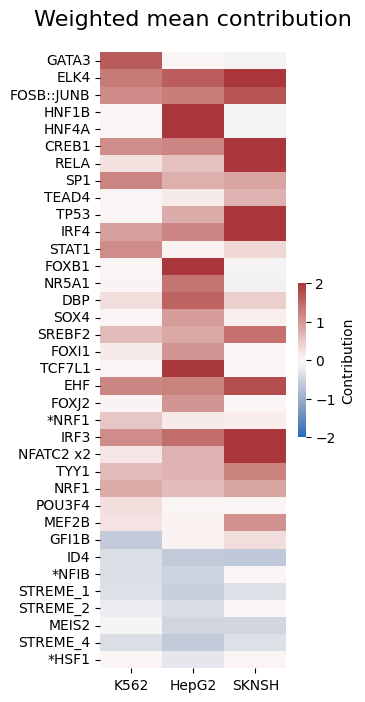

In [ ]:
plt.figure(figsize=(3,8))
sns.heatmap(all_motif_contributions, vmin=-2, vmax=2, cmap="vlag",
            cbar_kws={'label': 'Contribution', "shrink": .25})
plt.yticks(np.arange(0, len(custom_motif_names))+0.5, labels=custom_motif_names, rotation=0)
plt.xticks(np.arange(3)+0.5, labels=['K562', 'HepG2', 'SKNSH'])
plt.title('Weighted mean contribution', y=1.03, fontsize=16)
plt.show()

# Motif similarity

In [ ]:
max_motif_length = np.max([pwm.shape[-1] for pwm in core_motif_pwms])

PSSMs = torch.stack([utils.pad_seq_tensor(pwm, pad_len=max_motif_length) for pwm in core_motif_pwms])
PSSMs_rc = torch.stack([utils.pad_seq_tensor(pwm, pad_len=max_motif_length) for pwm in core_motif_pwms_rc])
filters = torch.cat([PSSMs, PSSMs_rc])

In [ ]:
pad_len = max_motif_length + 1
num_motifs = len(core_motif_pwms)
icms_as_double_list = [core_motif_icms, core_motif_icms_rc]

pearsons = np.zeros((num_motifs, num_motifs))
for motif_idx, motif_pwm in enumerate(tqdm(core_motif_pwms)):
    padded_pwm = double_pad_seq_tensor(motif_pwm, pad_len=pad_len)

    scan_scores = F.conv1d(padded_pwm.view(1,4,-1), filters)
    values, indices = scan_scores.max(dim=-1)
    values, indices = values.numpy().flatten(), indices.numpy().flatten()

    stacked_values = np.stack([values[:num_motifs], values[num_motifs:]])
    stacked_indices = np.stack([indices[:num_motifs], indices[num_motifs:]])
    rc_flags = stacked_values.argmax(axis=0)

    padded_icm = double_pad_seq_tensor(core_motif_icms[motif_idx], pad_len=pad_len)
    for i in range(num_motifs):
        rc_flag = rc_flags[i]
        position = stacked_indices[rc_flag, i]
        match_icm = icms_as_double_list[rc_flag][i]

        padded_match_icm = torch.zeros_like(padded_icm)
        padded_match_icm[:, position:position+match_icm.shape[1]] = match_icm
        pearson = np.corrcoef(padded_icm.flatten().numpy(), padded_match_icm.flatten().numpy())[0, 1]
        pearsons[motif_idx, i] = max(pearson, 0)

pearsons = np.maximum(pearsons, pearsons.T)

  0%|          | 0/36 [00:00<?, ?it/s]

Number of clusters: 9


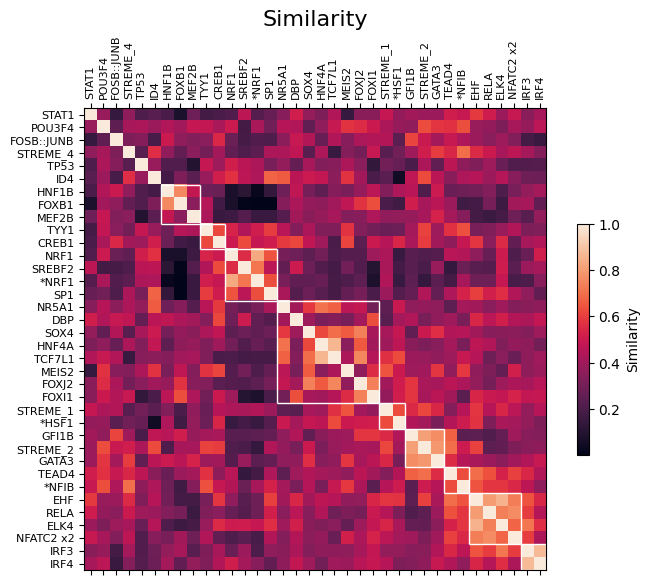

In [ ]:
random_seed = 1

# Convert similarity matrix to distance matrix
similarity_matrix = pearsons #** 2
distance_matrix = 1 - similarity_matrix

# Create an HDBSCAN instance
#clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=2, metric='precomputed')
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1)

# Fit the clusterer to the data
cluster_labels = clusterer.fit_predict(distance_matrix)

# Get the indices to re-arrange the similarity matrix
sorted_indices = np.argsort(cluster_labels)
rearranged_similarity_matrix = similarity_matrix[sorted_indices][:, sorted_indices]

names = np.array(custom_motif_names)
sorted_names = names[sorted_indices]

# Get unique cluster labels (excluding noise)
unique_labels = np.unique(cluster_labels)
unique_labels = unique_labels[unique_labels != -1]  # Exclude noise label

# Print the number of clusters
num_clusters = len(unique_labels)
print(f"Number of clusters: {num_clusters}")

# Create a figure and axes
plt.figure(figsize=(8, 6))
ax = plt.gca()
# Plot the heatmap
cax = ax.matshow(rearranged_similarity_matrix, cmap='rocket')
# Draw white lines between clusters
cluster_boundaries = [0]
current_cluster_label = cluster_labels[sorted_indices[0]]
cluster_start_index = 0
for i, label in enumerate(cluster_labels[sorted_indices]):
    if label != current_cluster_label:
        #cluster_boundaries.append((cluster_start_index, i))
        cluster_boundaries.append(i)
        current_cluster_label = label
        cluster_start_index = i
cluster_boundaries.append(num_motifs)
for i in range(1, len(cluster_boundaries[:-1])):
    boundary_start, boundary_end = cluster_boundaries[i] - 0.5, cluster_boundaries[i+1] - 0.5
    ax.hlines(y=boundary_start, xmin=boundary_start, xmax=boundary_end, color='white', linewidth=1)
    ax.vlines(x=boundary_start, ymin=boundary_start, ymax=boundary_end, color='white', linewidth=1)
    ax.hlines(y=boundary_end, xmin=boundary_start, xmax=boundary_end, color='white', linewidth=1)
    ax.vlines(x=boundary_end, ymin=boundary_start, ymax=boundary_end, color='white', linewidth=1)

plt.title("Similarity", fontsize=16)
plt.colorbar(cax, label='Similarity', shrink=0.5)

all_ticks = np.arange(0, num_motifs) #+ 0.5
plt.xticks(all_ticks, labels=sorted_names, rotation=90, fontsize=8)
plt.yticks(all_ticks, labels=sorted_names, rotation=0, fontsize=8)

plt.show()

# Motif contribution clustered by similarity

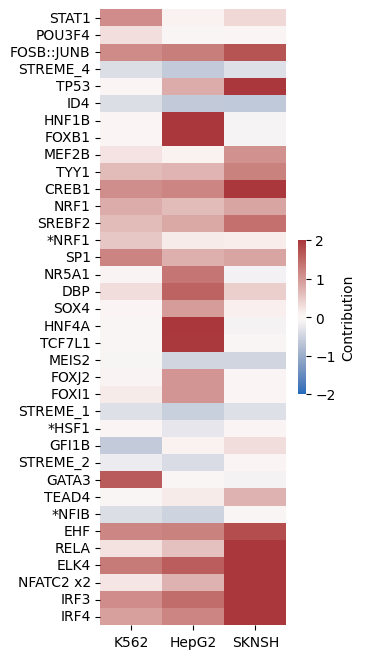

In [ ]:
motif_labels = [custom_motif_names[i] for i in sorted_indices]

plt.figure(figsize=(3,8))
sns.heatmap(all_motif_contributions[sorted_indices, :], vmin=-2, vmax=2, cmap="vlag",
            cbar_kws={'label': 'Contribution', "shrink": .25})
plt.yticks(np.arange(0, len(custom_motif_names))+0.5, labels=motif_labels, rotation=0)
plt.xticks(np.arange(3)+0.5, labels=['K562', 'HepG2', 'SKNSH'])
plt.show()

# Ocurrence stats

In [ ]:
natural_methods = ['DHS', 'gs']

num_naturals = coda_library_df['method'].isin(natural_methods).sum()
num_synthetics = coda_library_df['method'].isin(['sa', 'al', 'fsp']).sum()
num_all_seqs = len(coda_library_df)
num_naturals, num_synthetics, num_all_seqs

natural_pcts = []
synthetic_pcts = []
total_pcts = []
for motif_id in tqdm(motif_ids):
    hit_seqs = fimo_df[fimo_df['motif_id'] == motif_id]['sequence_name'].unique()
    motif_boda2_df = coda_library_df[coda_library_df['ID'].isin(hit_seqs)].reset_index(drop=True)
    motif_num_naturals = motif_boda2_df['method'].isin(natural_methods).sum()
    motif_num_synthetics = motif_boda2_df['method'].isin(['sa', 'al', 'fsp']).sum()
    natural_pcts.append(motif_num_naturals/num_naturals)
    synthetic_pcts.append(motif_num_synthetics/num_synthetics)
    total_pcts.append(len(motif_boda2_df)/num_all_seqs)

  0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
print(synthetic_pcts[3], natural_pcts[3])
print(synthetic_pcts[3]  /natural_pcts[3])
print(synthetic_pcts[2], natural_pcts[2])
print(synthetic_pcts[2] / natural_pcts[2])
print('')
print(synthetic_pcts[1], natural_pcts[1])
print(synthetic_pcts[1] / natural_pcts[1])
print(synthetic_pcts[9], natural_pcts[9])
print(synthetic_pcts[9] / natural_pcts[9])

0.1904705882352941 0.15420833333333334
1.2351510720473005
0.1239607843137255 0.08316666666666667
1.4905104326299659

0.06625490196078432 0.024041666666666666
2.755836476705067
0.07213725490196078 0.048625
1.483542517263975


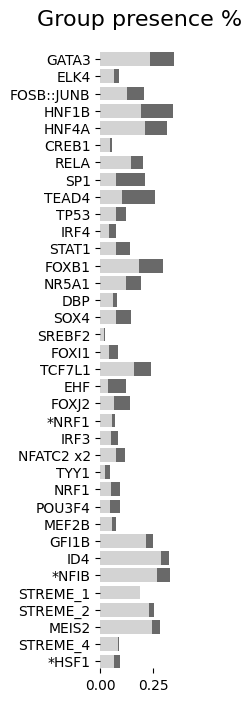

In [ ]:
idx_clustering = np.arange(0, num_motifs) #np.arange(0, num_motifs) #clustered_topic_idxs #clustered_motif_idxs

clustered_motif_labels = np.array(custom_motif_names)[np.ix_(idx_clustering)]
clustered_natural_pcts = np.array(natural_pcts)[np.ix_(idx_clustering)]
clustered_synthetic_pcts = np.array(synthetic_pcts)[np.ix_(idx_clustering)]

plt.figure(figsize=(1,8))
b1 = plt.barh(clustered_motif_labels, clustered_synthetic_pcts, color="lightgray")
b2 = plt.barh(clustered_motif_labels, clustered_natural_pcts, left=clustered_synthetic_pcts, color="dimgray")

#plt.legend([b1, b2], ["Synthetics", "Naturals"], title="Group", fontsize=8, loc='best')
#plt.xlabel('Occurrence percentage', fontsize=12)
plt.gca().invert_yaxis()
plt.margins(y=0)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
#plt.yticks([])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig(f"/content/drive/MyDrive/figures/motif_usage.pdf", bbox_inches = 'tight', pad_inches=0, dpi=200)
plt.title('Group presence %', y=1.03, fontsize=16)
plt.show()

  0%|          | 0/36 [00:00<?, ?it/s]

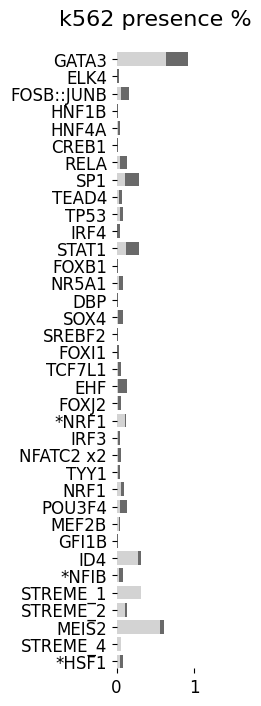

  0%|          | 0/36 [00:00<?, ?it/s]

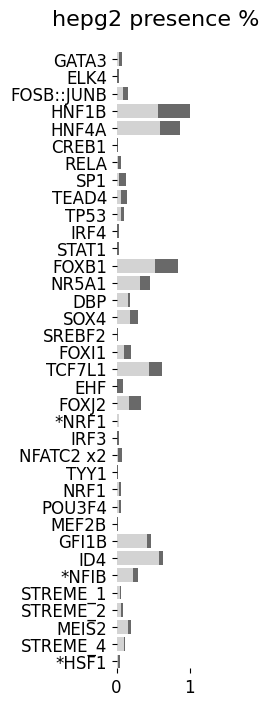

  0%|          | 0/36 [00:00<?, ?it/s]

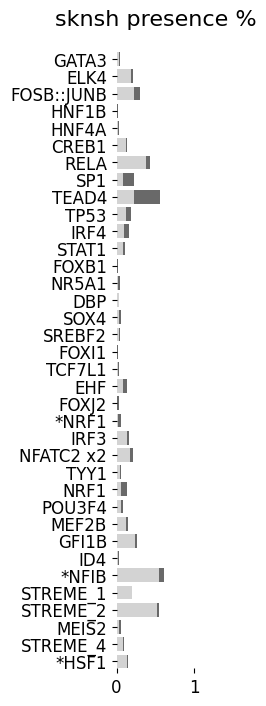

In [ ]:
idx_clustering = np.arange(0, num_motifs) #np.arange(0, num_motifs) #clustered_topic_idxs #clustered_motif_idxs
clustered_motif_labels = np.array(custom_motif_names)[np.ix_(idx_clustering)]

natural_methods = ['DHS', 'gs']
synthetic_methods = ['sa', 'al', 'fsp']

for target_cell in ['k562', 'hepg2', 'sknsh']:
    cell_df = coda_library_df[coda_library_df['target_cell'] == target_cell].reset_index(drop=True)
    cell_num_naturals = cell_df['method'].isin(natural_methods).sum()
    cell_num_synthetics = cell_df['method'].isin(['sa', 'al', 'fsp']).sum()
    cell_num_all_seqs = len(cell_df)

    cell_natural_pcts = []
    cell_synthetic_pcts = []
    cell_total_pcts = []
    for motif_id in tqdm(motif_ids):
        hit_seqs = fimo_df[fimo_df['motif_id'] == motif_id]['sequence_name'].unique()
        motif_boda2_df = cell_df[cell_df['ID'].isin(hit_seqs)].reset_index(drop=True)
        motif_num_naturals = motif_boda2_df['method'].isin(natural_methods).sum()
        motif_num_synthetics = motif_boda2_df['method'].isin(synthetic_methods).sum()
        cell_natural_pcts.append(motif_num_naturals/cell_num_naturals)
        cell_synthetic_pcts.append(motif_num_synthetics/cell_num_synthetics)
        cell_total_pcts.append(len(motif_boda2_df)/cell_num_all_seqs)

    clustered_natural_pcts = np.array(cell_natural_pcts)[np.ix_(idx_clustering)]
    clustered_synthetic_pcts = np.array(cell_synthetic_pcts)[np.ix_(idx_clustering)]

    plt.figure(figsize=(1,8))
    b1 = plt.barh(clustered_motif_labels, clustered_synthetic_pcts, color="lightgray")
    b2 = plt.barh(clustered_motif_labels, clustered_natural_pcts, left=clustered_synthetic_pcts, color="dimgray")

    #plt.legend([b1, b2], ["Synthetic", "Natural"], title="Group", fontsize=8)
    #plt.xlabel('Occurrence percentage', fontsize=12)
    plt.gca().invert_yaxis()
    plt.margins(y=0)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    #plt.yticks([])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks([0,1])
    #plt.savefig(f"/content/drive/MyDrive/figures/motif_usage_{target_cell}_revised.pdf", bbox_inches = 'tight', pad_inches=0, dpi=200)
    plt.title(f'{target_cell} presence %', y=1.03, fontsize=16)
    plt.show()

In [ ]:
num_seqs_k562 = (coda_library_df['target_cell'] == 'k562').sum()
num_seqs_hepg2 = (coda_library_df['target_cell'] == 'hepg2').sum()
num_seqs_sknsh = (coda_library_df['target_cell'] == 'sknsh').sum()

k562_pcts = []
hepg2_pcts = []
sknsh_pcts = []
for motif_id in tqdm(motif_ids):
    hit_seqs = fimo_df[fimo_df['motif_id'] == motif_id]['sequence_name'].unique()
    motif_boda2_df = coda_library_df[coda_library_df['ID'].isin(hit_seqs)].reset_index(drop=True)
    # k562_pcts.append( (motif_boda2_df['target_cell'] == 'k562').sum() / num_all_seqs )
    # hepg2_pcts.append( (motif_boda2_df['target_cell'] == 'hepg2').sum() / num_all_seqs )
    # sknsh_pcts.append( (motif_boda2_df['target_cell'] == 'sknsh').sum() / num_all_seqs )
    k562_pcts.append( (motif_boda2_df['target_cell'] == 'k562').sum() / num_seqs_k562 )
    hepg2_pcts.append( (motif_boda2_df['target_cell'] == 'hepg2').sum() / num_seqs_hepg2 )
    sknsh_pcts.append( (motif_boda2_df['target_cell'] == 'sknsh').sum() / num_seqs_sknsh )

  0%|          | 0/36 [00:00<?, ?it/s]

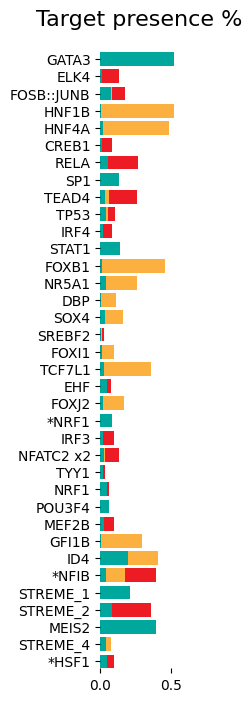

In [ ]:
idx_clustering = np.arange(0, num_motifs) #np.arange(0, num_motifs) #clustered_topic_idxs #clustered_motif_idxs
clustered_motif_labels = np.array(custom_motif_names)[np.ix_(idx_clustering)]

clustered_k562_pcts = np.array(k562_pcts)[np.ix_(idx_clustering)]
clustered_hepg2_pcts = np.array(hepg2_pcts)[np.ix_(idx_clustering)]
clustered_sknsh_pcts = np.array(sknsh_pcts)[np.ix_(idx_clustering)]

plt.figure(figsize=(1,8))
b3 = plt.barh(clustered_motif_labels, clustered_sknsh_pcts, color="#ED1C24")
b2 = plt.barh(clustered_motif_labels, clustered_hepg2_pcts, color="#FBB040")
b1 = plt.barh(clustered_motif_labels, clustered_k562_pcts, color='#00A79D')

#plt.legend([b1, b2], ["Naturals", "Synthetics"], title="Group", fontsize=8)
#plt.xlabel('Enrichment', fontsize=12)
plt.gca().invert_yaxis()
plt.margins(y=0)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
#plt.yticks([])
#plt.xticks([])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)#, color='#002D72')
#plt.savefig(f"/content/drive/MyDrive/figures/motif_target_enrichment.pdf", bbox_inches = 'tight', pad_inches=0, dpi=200)
plt.title('Target presence %', y=1.03, fontsize=16)
plt.show()

# Co-occurrence stats

In [ ]:
import bottleneck as bn

def top_n_indexes(arr, n):
    idx = bn.argpartition(arr, arr.size-n, axis=None)[-n:]
    width = arr.shape[1]
    return [divmod(i, width) for i in idx]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

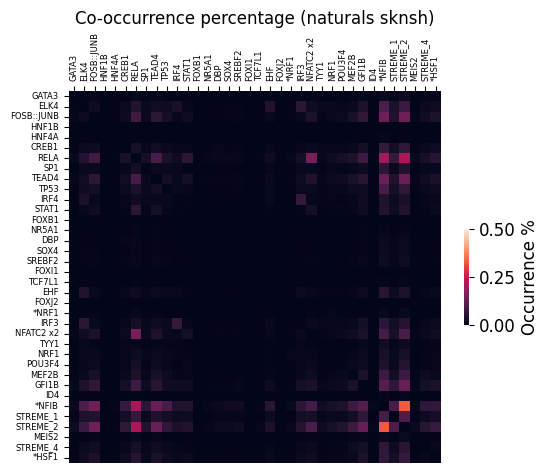

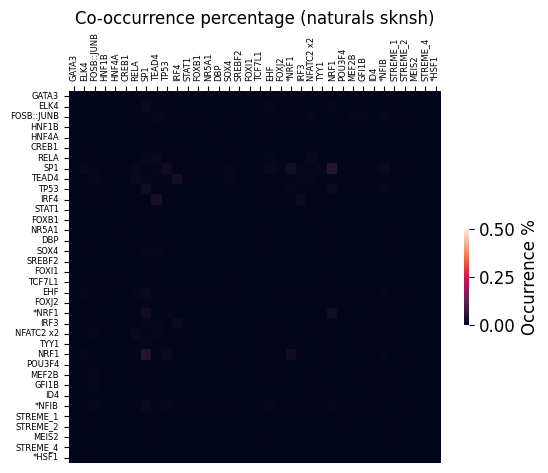

In [ ]:
target_cells = ['sknsh'] #['k562', 'hepg2', 'sknsh']

#--- Co-occurrence difference
motif_list = motif_ids.copy()
ultimate_ids = custom_motif_names.copy()
precise_library_df = coda_library_df.copy()


#--- Group 1
methods = ['fsp', 'al', 'sa']
#methods = ['DHS', 'gs']
#methods = ['DHS', 'gs', 'fsp', 'al', 'sa']
 #['k562', 'hepg2', 'sknsh']

group_df = precise_library_df[precise_library_df['method'].isin(methods) & precise_library_df['target_cell'].isin(target_cells)].reset_index(drop=True)
#-For non-penalized
#group_df = group_df[group_df['round'].isin([0])].reset_index(drop=True)

for motif_id in tqdm(motif_list):
    motif_seq_set = fimo_df[fimo_df['motif_id'] == motif_id]['sequence_name'].unique()
    seq_filter = group_df['ID'].isin(motif_seq_set)
    group_df[motif_id] = 0
    group_df.loc[seq_filter, motif_id] = 1

group_df.rename(dict(zip(motif_list, ultimate_ids)), axis=1, inplace=True)
num_seqs_1 = len(group_df)

all_sequence_sets_1 = []
coocurrence_counts = np.zeros((num_motifs, num_motifs))
for i in tqdm(range(num_motifs)):
    row_sequence_sets = []
    for j in range(i+1, num_motifs):
        coocurrence_filter = (group_df[ultimate_ids[i]] == 1) & (group_df[ultimate_ids[j]] == 1)
        seq_ids = group_df[coocurrence_filter]['ID'].tolist()
        coocurrence_counts[i,j] = len(seq_ids)
        row_sequence_sets.append(seq_ids)
    all_sequence_sets_1.append((row_sequence_sets))
coocurrence_pcts = coocurrence_counts / num_seqs_1
coocurrence_pcts = coocurrence_pcts + coocurrence_pcts.T

sorted_coocurrence_1 = coocurrence_pcts #[np.ix_(clustered_motif_idxs, clustered_motif_idxs)]

#--- Group 2
#methods = ['fsp', 'al', 'sa']
methods = ['DHS', 'gs']
#methods = ['DHS']
#methods = ['DHS', 'gs', 'fsp', 'al', 'sa']

group_df = precise_library_df[precise_library_df['method'].isin(methods) & precise_library_df['target_cell'].isin(target_cells)].reset_index(drop=True)

#-For penalized:
# group_df = precise_library_df[precise_library_df['round'].isin([1,2,3,4,5]) & precise_library_df['target_cell'].isin(target_cells)].reset_index(drop=True)
# group_df = group_df[group_df['method'].isin(['fsp'])].reset_index(drop=True)
#---

for motif_id in tqdm(motif_list):
    motif_seq_set = fimo_df[fimo_df['motif_id'] == motif_id]['sequence_name'].unique()
    seq_filter = group_df['ID'].isin(motif_seq_set)
    group_df[motif_id] = 0
    group_df.loc[seq_filter, motif_id] = 1

group_df.rename(dict(zip(motif_list, ultimate_ids)), axis=1, inplace=True)
num_seqs_2 = len(group_df)

all_sequence_sets_2 = []
coocurrence_counts = np.zeros((num_motifs, num_motifs))
for i in tqdm(range(num_motifs)):
    row_sequence_sets = []
    for j in range(i+1, num_motifs):
        coocurrence_filter = (group_df[ultimate_ids[i]] == 1) & (group_df[ultimate_ids[j]] == 1)
        seq_ids = group_df[coocurrence_filter]['ID'].tolist()
        coocurrence_counts[i,j] = len(seq_ids)
        row_sequence_sets.append(seq_ids)
    all_sequence_sets_2.append((row_sequence_sets))
coocurrence_pcts = coocurrence_counts / num_seqs_2
coocurrence_pcts = coocurrence_pcts + coocurrence_pcts.T

sorted_coocurrence_2 = coocurrence_pcts #[np.ix_(clustered_motif_idxs, clustered_motif_idxs)]

figsize = (6, 5)
all_ticks = np.arange(0, num_motifs) + 0.5
fit_data = distance_matrix.copy()
above_distance_matrix = fit_data * (sorted_coocurrence_1 - sorted_coocurrence_2)
#above_distance_matrix = (sorted_coocurrence_1 - sorted_coocurrence_2)
# with plt.style.context('fivethirtyeight'):
#     plt.figure(figsize=figsize)
#     g = sns.heatmap(above_distance_matrix, square=True, vmin=-0.5, vmax=0.5, cmap="viridis",
#                     cbar_kws={'label': '', "shrink": .25})
#     plt.xticks(all_ticks, labels=custom_motif_names, rotation=90, fontsize=6)
#     plt.yticks(all_ticks, labels=custom_motif_names, rotation=0, fontsize=6)
#     g.figure.axes[-1].yaxis.label.set_size(12)
#     g.figure.axes[-1].tick_params(labelsize=12)
#     g.xaxis.tick_top()
#     # g.yaxis.tick_right()
#     plt.grid(False)
#     plt.title('Co-occurrence weighted by motif distance')

#     plt.show()

plt.figure(figsize=figsize)
g = sns.heatmap(sorted_coocurrence_1, square=True, vmin=0, vmax=0.5, cmap="rocket",
                cbar_kws={'label': 'Occurrence %', "shrink": .25})
plt.xticks(all_ticks, labels=custom_motif_names, rotation=90, fontsize=6)
plt.yticks(all_ticks, labels=custom_motif_names, rotation=0, fontsize=6)
g.figure.axes[-1].yaxis.label.set_size(12)
g.figure.axes[-1].tick_params(labelsize=12)
g.xaxis.tick_top()
# g.yaxis.tick_right()
plt.grid(False)
plt.title('Co-occurrence percentage (naturals ' + ' '.join(target_cells) + ')')
plt.show()

plt.figure(figsize=figsize)
g = sns.heatmap(sorted_coocurrence_2, square=True, vmin=0, vmax=0.5, cmap="rocket",
                cbar_kws={'label': 'Occurrence %', "shrink": .25})
plt.xticks(all_ticks, labels=custom_motif_names, rotation=90, fontsize=6)
plt.yticks(all_ticks, labels=custom_motif_names, rotation=0, fontsize=6)
g.figure.axes[-1].yaxis.label.set_size(12)
g.figure.axes[-1].tick_params(labelsize=12)
g.xaxis.tick_top()
# g.yaxis.tick_right()
plt.grid(False)
plt.title('Co-occurrence percentage (naturals ' + ' '.join(target_cells) + ')')
plt.show()

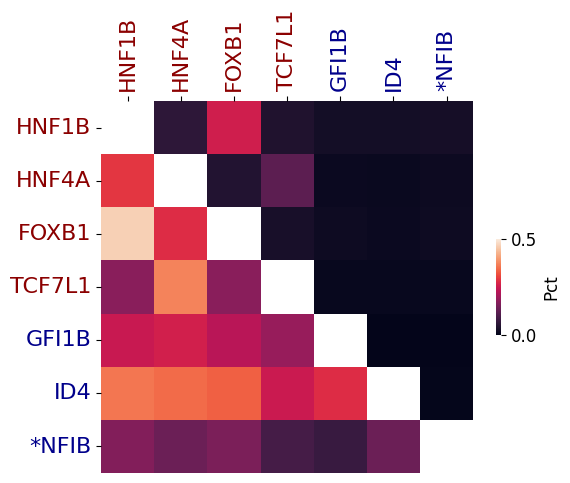

77.2 16.4


In [ ]:
n_top = 20 #20 #50

#---Motif label colors
contrib_means = all_motif_contributions.mean(dim=-1)
pos_idxs = torch.where(contrib_means > 0)[0].tolist()
neg_idxs = torch.where(contrib_means <= 0)[0].tolist()
motif_colors = ['darkred' if (i in pos_idxs) else 'darkblue' for i in range(82)]

some_matrix = fit_data * (sorted_coocurrence_1 - sorted_coocurrence_2)
top_idxs = top_n_indexes(some_matrix, n_top)
top_idxs = sorted(set([item for t in top_idxs for item in t]))

reduced_ticks = np.arange(0.5, len(top_idxs) + 0.5, 1)
reduced_labels = [clustered_motif_labels[j] for j in top_idxs]
reduced_colors = [motif_colors[j] for j in top_idxs]

#---Cooccurrence
plot_matrix_l = (sorted_coocurrence_1)[np.ix_(top_idxs, top_idxs)]
plot_matrix_u = (sorted_coocurrence_2)[np.ix_(top_idxs, top_idxs)]

mask_u = np.zeros_like(plot_matrix_u, dtype=bool)
mask_u[np.triu_indices_from(mask_u)] = True

mask_l = np.zeros_like(plot_matrix_l, dtype=bool)
mask_l[np.tril_indices_from(mask_l)] = True

plot_matrix = mask_l * plot_matrix_l + mask_u * plot_matrix_u

#zeros = np.zeros_like(plot_matrix, dtype=bool)
mask = np.eye(len(top_idxs))

max_color = 0.5 #np.round(plot_matrix.max(), 2) #0.45 #np.round(plot_matrix.max(), 2)
figsize = (6, 5)
with plt.style.context('fast'):
    plt.figure(figsize=figsize)
    g = sns.heatmap(plot_matrix, square=True, vmin=0, vmax=max_color, cmap="rocket", mask=mask,
                    cbar_kws={'label': 'Pct', "shrink": .25, "ticks":[0, max_color]})
    plt.xticks(reduced_ticks, labels=reduced_labels, rotation=90, fontsize=16)
    plt.yticks(reduced_ticks, labels=reduced_labels, rotation=0, fontsize=16)

    g.figure.axes[-1].yaxis.label.set_size(12)
    g.figure.axes[-1].tick_params(labelsize=12)
    g.xaxis.tick_top()
    for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), reduced_colors):
        ticklabel.set_color(tickcolor)
    for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), reduced_colors):
        ticklabel.set_color(tickcolor)
    # g.yaxis.tick_right()
    plt.grid(False)
    #plt.title('Co-occurrence weighted by motif distance')
    save_path = f'/content/drive/MyDrive/figures/motif_cooccurrence/top50_motif_cooccurrence_raw_{target_cells[0]}_v2.pdf'
    #plt.savefig(save_path, format='pdf', dpi=150, bbox_inches='tight', transparent=True)
    plt.show()

#----
top_idx_set = set(sorted([tuple(sorted(idx_pair)) for idx_pair in top_n_indexes(some_matrix, n_top)]))

topn_seq_set_1 = []
topn_seq_set_2 = []
for idx_pair in top_idx_set:
    topn_seq_set_1 += all_sequence_sets_1[idx_pair[0]][idx_pair[1] - idx_pair[0] - 1]
    topn_seq_set_2 += all_sequence_sets_2[idx_pair[0]][idx_pair[1] - idx_pair[0] - 1]

set_pct_1 = len(set(topn_seq_set_1))/num_seqs_1
set_pct_2 = len(set(topn_seq_set_2))/num_seqs_2
print(np.round(100*set_pct_1, 1), np.round(100*set_pct_2, 1))

# global_id_set_1 += list(set(topn_seq_set_1))
# global_id_set_2 += list(set(topn_seq_set_2))

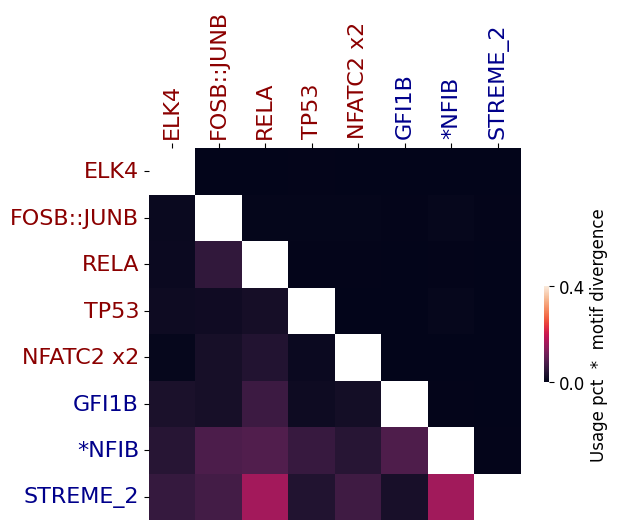

In [ ]:
reduced_ticks = np.arange(0.5, len(top_idxs) + 0.5, 1)
reduced_labels = [clustered_motif_labels[j] for j in top_idxs]

plot_matrix_l = (distance_matrix * sorted_coocurrence_1)[np.ix_(top_idxs, top_idxs)]
plot_matrix_u = (distance_matrix * sorted_coocurrence_2)[np.ix_(top_idxs, top_idxs)]

mask_u = np.zeros_like(plot_matrix, dtype=bool)
mask_u[np.triu_indices_from(mask)] = True

mask_l = np.zeros_like(plot_matrix, dtype=bool)
mask_l[np.tril_indices_from(mask)] = True

plot_matrix = mask_l * plot_matrix_l + mask_u * plot_matrix_u

#zeros = np.zeros_like(plot_matrix, dtype=bool)
mask = np.eye(len(top_idxs))

max_color = 0.4 #np.round(plot_matrix.max(), 2) #0.45 #np.round(plot_matrix.max(), 2)
figsize = (6, 5)
with plt.style.context('fast'):
    plt.figure(figsize=figsize)
    g = sns.heatmap(plot_matrix, square=True, vmin=0, vmax=max_color, cmap="rocket", mask=mask,
                    cbar_kws={'label': 'Usage pct  *  motif divergence', "shrink": .25, "ticks":[0, max_color]})
    plt.xticks(reduced_ticks, labels=reduced_labels, rotation=90, fontsize=16)
    plt.yticks(reduced_ticks, labels=reduced_labels, rotation=0, fontsize=16)
    g.figure.axes[-1].yaxis.label.set_size(12)
    g.figure.axes[-1].tick_params(labelsize=12)
    g.xaxis.tick_top()
    for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), reduced_colors):
        ticklabel.set_color(tickcolor)
    for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), reduced_colors):
        ticklabel.set_color(tickcolor)
    # g.yaxis.tick_right()
    # g.yaxis.tick_right()
    plt.grid(False)
    #plt.title('Co-occurrence weighted by motif distance')
    save_path = f'/content/drive/MyDrive/figures/motif_cooccurrence/top50_motif_cooccurrence_corrected_{target_cells[0]}_v3.pdf'
    #plt.savefig(save_path, format='pdf', bbox_inches='tight', transparent=True) #dpi=150,
    #plt.savefig('whatever.pdf', bbox_inches='tight', transparent=True)
    plt.show()

# Type/token

In [ ]:
matches = fimo_df.groupby('sequence_name').motif_id.apply(list).reset_index()
matches.rename({'sequence_name':'ID'}, axis=1, inplace=True)

In [ ]:
matches_df = matches.merge(coda_library_df, on='ID', how='inner')

matches_df['token'] = matches_df.progress_apply(lambda x: len(x['motif_id']), axis=1)
matches_df['type'] = matches_df.progress_apply(lambda x: len(set(x['motif_id'])), axis=1)

matches_df['type/token'] = matches_df['type'] / matches_df['token']

  0%|          | 0/71002 [00:00<?, ?it/s]

  0%|          | 0/71002 [00:00<?, ?it/s]

In [ ]:
dhs_annotation_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/satellite_repeat_annotations/DHS.Control.Satellite.Simple.Repeats.txt', sep='\t')
mal_annotation_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/satellite_repeat_annotations/Malinois.Natural.Satellite.Simple.Repeats.txt', sep='\t')

dhs_annotation_df['Seq ID'] = [x[0] for x in dhs_annotation_df['Seq ID'].str.split(':')]
mal_annotation_df['Seq ID'] = [(':').join(x[:2]) for x in mal_annotation_df['Seq ID'].str.split(':').tolist()]

repetitive_seqs = set(dhs_annotation_df['Seq ID'].tolist() + mal_annotation_df['Seq ID'].tolist())

In [ ]:
row_filter = matches_df['method'].isin(['DHS', 'gs'])
truncated_ids = [x[0] for x in matches_df.loc[row_filter]['ID'].str.split('::').tolist()]
matches_df.loc[row_filter, 'truncated_id'] = truncated_ids

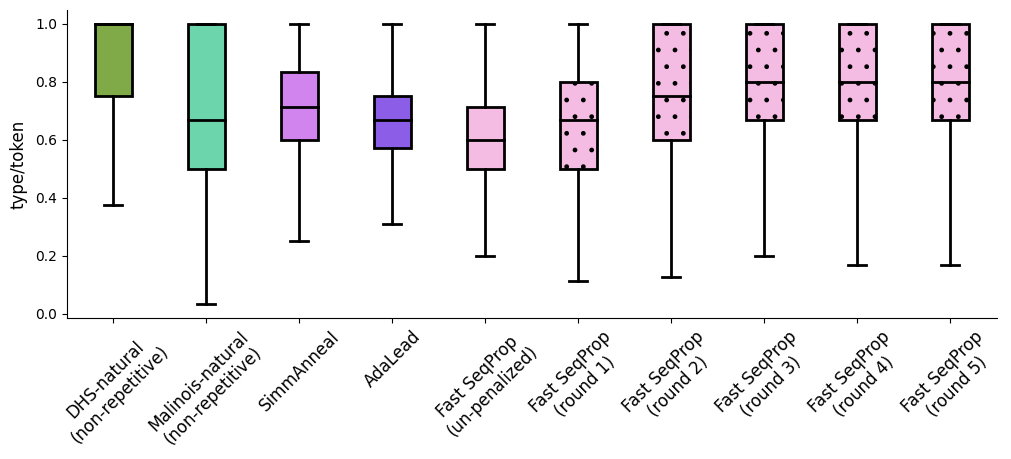

In [ ]:
conditon_1 = matches_df['method'].isin(['DHS', 'gs', 'sa', 'al']) & (matches_df['round'] == 0)
condition_2 = matches_df['method'] == 'fsp'
plot_df = matches_df[conditon_1 | condition_2].reset_index(drop=True)

plot_df = plot_df[~plot_df['truncated_id'].isin(repetitive_seqs)].reset_index(drop=True)


row_filter = plot_df['method'] == 'fsp'
plot_df.loc[row_filter, 'method'] = 'Fast SeqProp\nround ' + plot_df[row_filter]['round'].astype(str)

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
order = ['DHS', 'gs', 'sa', 'al', 'Fast SeqProp\nround 0', 'Fast SeqProp\nround 1',
       'Fast SeqProp\nround 2', 'Fast SeqProp\nround 3',
       'Fast SeqProp\nround 4', 'Fast SeqProp\nround 5']
ordered_colors = ['#81BA37', '#5AE7AE', '#D972FF', '#8447FF'] + 6*['#FFB2E6']
hatches = 5*[''] + 5*['.']
with plt.style.context('fast'):
    plt.figure(figsize=(12,4))
    mpl.rcParams['lines.linewidth'] = 2.0
    g = sns.boxplot(data=plot_df, x='method', y='type/token', showfliers=False, order=order, width=0.4, palette=ordered_colors, **PROPS)
    patches = [patch for patch in g.patches if type(patch) == mpl.patches.PathPatch]
    h = hatches * (len(patches) // len(hatches))
    for patch, hatch in zip(patches, h):
        patch.set_hatch(hatch)
        patch.set_edgecolor('k')
    g.spines['top'].set_visible(False)
    g.spines['right'].set_visible(False)
    plt.xlabel('')
    g.set_xticklabels(['DHS-natural\n(non-repetitive)', 'Malinois-natural\n(non-repetitive)', 'SimmAnneal', 'AdaLead', 'Fast SeqProp\n(un-penalized)',
                       'Fast SeqProp\n(round 1)', 'Fast SeqProp\n(round 2)', 'Fast SeqProp\n(round 3)', 'Fast SeqProp\n(round 4)', 'Fast SeqProp\n(round 5)'],
                      fontsize=12, rotation=45)
    plt.ylabel('type/token', labelpad=5, fontsize=12)
    savepath = f'/content/drive/MyDrive/figures/type_token/type_token_all_methods_boxplot.pdf'
    #plt.savefig(savepath, format='pdf', transparent=True, dpi=150, bbox_inches='tight')
    plt.show()

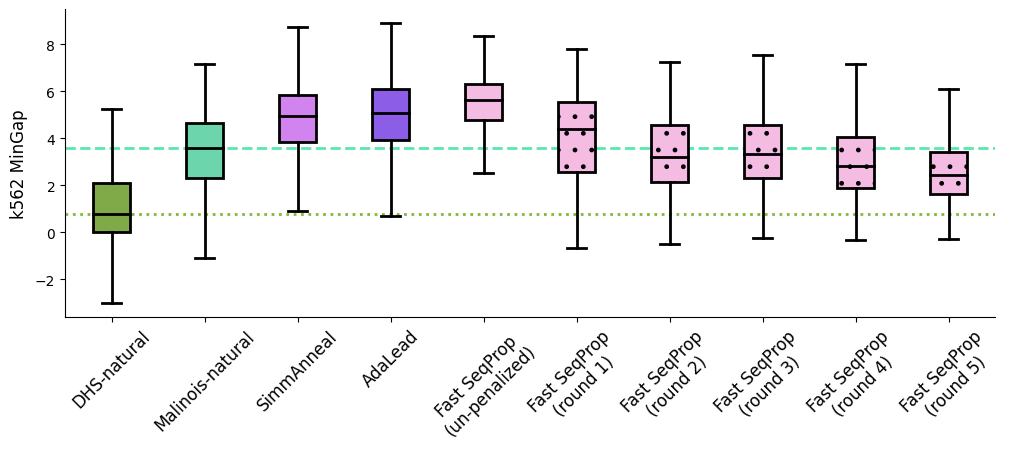

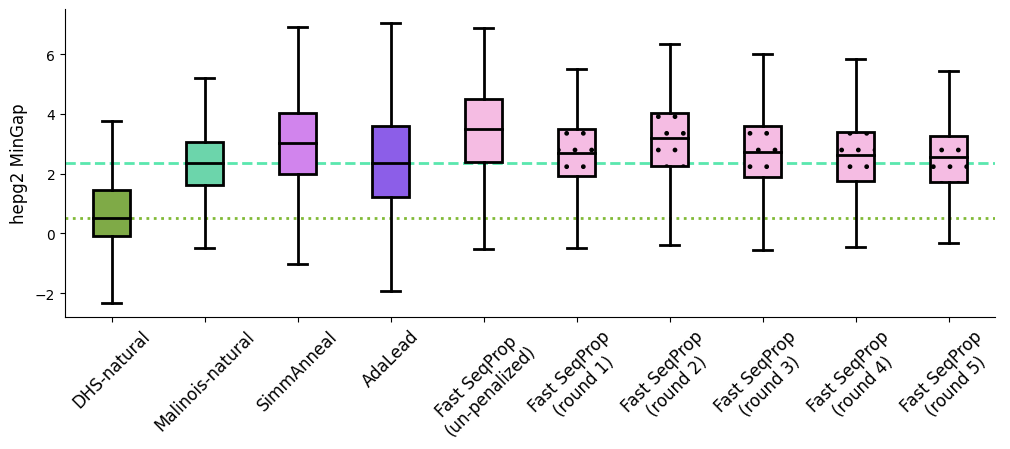

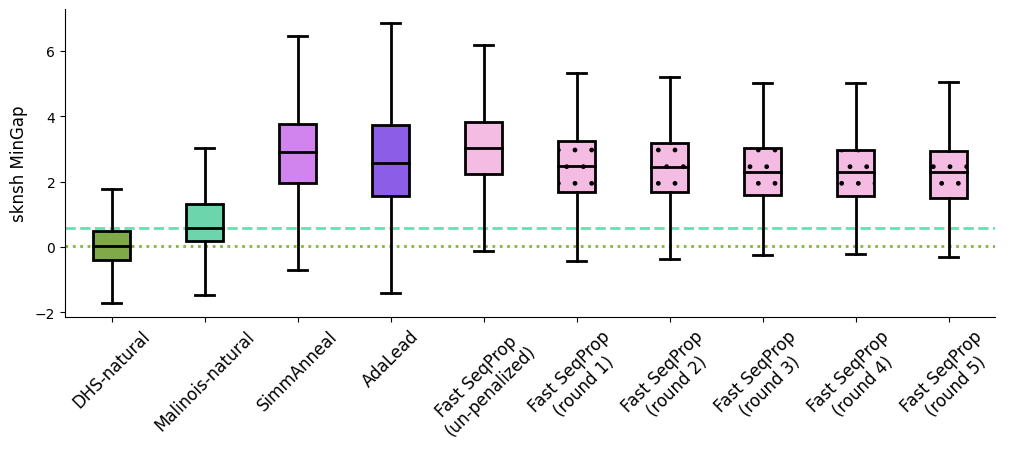

In [ ]:
conditon_1 = boda2_df['method'].isin(['DHS', 'gs', 'sa', 'al']) & (boda2_df['round'] == 0)
condition_2 = boda2_df['method'] == 'fsp'
plot_df = boda2_df[conditon_1 | condition_2].reset_index(drop=True)

#plot_df = plot_df[~plot_df['truncated_id'].isin(repetitive_seqs)].reset_index(drop=True)
quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
plot_df = plot_df[quality_filter].reset_index(drop=True)

row_filter = plot_df['method'] == 'fsp'
plot_df.loc[row_filter, 'method'] = 'Fast SeqProp\nround ' + plot_df[row_filter]['round'].astype(str)

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
order = ['DHS', 'gs', 'sa', 'al', 'Fast SeqProp\nround 0', 'Fast SeqProp\nround 1',
       'Fast SeqProp\nround 2', 'Fast SeqProp\nround 3',
       'Fast SeqProp\nround 4', 'Fast SeqProp\nround 5']
ordered_colors = ['#81BA37', '#5AE7AE', '#D972FF', '#8447FF'] + 6*['#FFB2E6']
hatches = 5*[''] + 5*['.']

target_cells = ['k562', 'hepg2', 'sknsh']
for target_cell in target_cells:
    with plt.style.context('fast'):
        plt.figure(figsize=(12,4))
        mpl.rcParams['lines.linewidth'] = 2.0
        temp_df = plot_df[plot_df['target_cell'] == target_cell].reset_index(drop=True)
        med = temp_df[temp_df['method'] == 'gs']['OverMax'].median()
        med_2 = temp_df[temp_df['method'] == 'DHS']['OverMax'].median()
        plt.hlines(med, -0.5, 9.5, linestyle='dashed', color=ordered_colors[1], zorder=0, alpha=1)
        plt.hlines(med_2, -0.5, 9.5, linestyle='dotted', color=ordered_colors[0], zorder=0, alpha=1)
        g = sns.boxplot(data=temp_df, x='method', y='OverMax', showfliers=False, order=order, width=0.4, palette=ordered_colors, **PROPS)
        patches = [patch for patch in g.patches if type(patch) == mpl.patches.PathPatch]
        h = hatches * (len(patches) // len(hatches))
        for patch, hatch in zip(patches, h):
            patch.set_hatch(hatch)
            patch.set_edgecolor('k')
        g.spines['top'].set_visible(False)
        g.spines['right'].set_visible(False)
        plt.xlabel('')
        g.set_xticklabels(['DHS-natural', 'Malinois-natural', 'SimmAnneal', 'AdaLead', 'Fast SeqProp\n(un-penalized)',
                        'Fast SeqProp\n(round 1)', 'Fast SeqProp\n(round 2)', 'Fast SeqProp\n(round 3)', 'Fast SeqProp\n(round 4)', 'Fast SeqProp\n(round 5)'],
                        fontsize=12, rotation=45)
        plt.ylabel(f'{target_cell} MinGap', labelpad=5, fontsize=12)
        savepath = f'/content/drive/MyDrive/figures/MinGap/MinGap_all_methods_boxplot_{target_cell}.pdf'
        #plt.savefig(savepath, format='pdf', transparent=True, dpi=150, bbox_inches='tight')
        plt.show()

# Repetitive elements

In [ ]:
for element_id in mal_annotation_df['Seq ID'].tolist()[:50]:
    print(element_id)
    element_index = coda_library_df[coda_library_df['ID'] == element_id].index.item()
    element_contribution = all_contributions[2, element_index]
    y_max = element_contribution.max()
    matrix_to_dms(element_contribution, y_max=y_max, fontaspect=.55, widthscale=0.4,
                  axisfontscale=0.6, heightscale=0.8)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import random
random_ints = random.sample(range(len(library_not_in_fimo)), 20)
seq_sublist = [list(library_not_in_fimo)[j] for j in random_ints]

for seq_id in seq_sublist:
    seq_df = coda_library_df[coda_library_df['ID'] == seq_id]
    seq_idx = seq_df.index.item()

    k562_lfc = np.round(seq_df['K562_signal'].item(), 2)
    hepg2_lfc = np.round(seq_df['HepG2_signal'].item(), 2)
    sknsh_lfc = np.round(seq_df['SKNSH_signal'].item(), 2)

    target_cell = seq_df['target_cell'].item()

    print(f'{seq_id}  ({target_cell})|  K562 l2FC = {k562_lfc},  HepG2 l2FC = {hepg2_lfc},  SKNSH l2FC = {sknsh_lfc}')

    element_contribution = all_contributions[:, seq_idx, ...]
    y_max = element_contribution.max()
    for i in range(3):
        matrix_to_dms(element_contribution[i, ...], y_max=y_max, fontaspect=.55, widthscale=0.4,
                    axisfontscale=0.6, heightscale=0.8)
        plt.show()
    print()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
found_count = 0
for seq_id in list(library_not_in_fimo):

    seq_df = coda_library_df[coda_library_df['ID'] == seq_id]
    seq_idx = seq_df.index.item()

    k562_lfc = np.round(seq_df['K562_signal'].item(), 2)
    hepg2_lfc = np.round(seq_df['HepG2_signal'].item(), 2)
    sknsh_lfc = np.round(seq_df['SKNSH_signal'].item(), 2)

    target_cell = seq_df['target_cell'].item()

    if target_cell == 'k562':

        print(f'{seq_id}  ({target_cell})|  K562 l2FC = {k562_lfc},  HepG2 l2FC = {hepg2_lfc},  SKNSH l2FC = {sknsh_lfc}')

        element_contribution = all_contributions[:, seq_idx, ...]
        y_max = element_contribution.max()
        for i in range(3):
            matrix_to_dms(element_contribution[i, ...], y_max=y_max, fontaspect=.55, widthscale=0.4,
                        axisfontscale=0.6, heightscale=0.8)
            plt.show()
        print()

        found_count +=1
    if found_count == 20:
        break

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
%%time
motif_legth_set = np.unique([icm.shape[-1] for icm in core_motif_icms])

cell_idx = 0
cell_contributions = all_contributions[cell_idx, ...]
window_len = motif_legth_set[0]

all_window_contribtutions = []
coord_list = []
for seq_idx in range(75000):
    for position in range(200 - window_len):
        all_window_contribtutions.append(cell_contributions[seq_idx, :, position:position+window_len])
        coord_list.append([seq_idx, position])

KeyboardInterrupt: ignored

In [ ]:
cell_idx = 0
cell_contributions = all_contributions[cell_idx, ...]
window_len = motif_legth_set[0]


# Assuming cell_contributions is a torch tensor of shape (75000, 4, 200)
# Create indices for all possible windows
indices = torch.arange(0, 200 - window_len + 1).unfold(0, window_len, 1)

# Initialize empty lists to store results
all_window_contributions = []
coord_list = []

# Loop over sequences
for seq_idx in range(75000):
    # Loop over positions
    for idx in indices:
        pos_indices = idx + torch.arange(window_len)

        # Extract windows and store in the list
        windows = cell_contributions[seq_idx, :, pos_indices]
        all_window_contributions.append(windows)

        # Store coordinates in the list
        coord_list.append([seq_idx, idx.item()])

# Stack the results into tensors
all_window_contributions = torch.stack(all_window_contributions)
coord_list = torch.tensor(coord_list)

coord_list = [(seq.item(), pos.item()) for seq, pos in zip(seq_idx.flatten(), pos_idx.flatten())]





NameError: ignored

In [ ]:
seq_indices, indices, seq_indices.shape, indices.shape

(tensor([[    0,     0,     0,  ...,     0,     0,     0],
         [    1,     1,     1,  ...,     1,     1,     1],
         [    2,     2,     2,  ...,     2,     2,     2],
         ...,
         [74997, 74997, 74997,  ..., 74997, 74997, 74997],
         [74998, 74998, 74998,  ..., 74998, 74998, 74998],
         [74999, 74999, 74999,  ..., 74999, 74999, 74999]]),
 tensor([[  0,   1,   2,  ...,   4,   5,   6],
         [  1,   2,   3,  ...,   5,   6,   7],
         [  2,   3,   4,  ...,   6,   7,   8],
         ...,
         [185, 186, 187,  ..., 189, 190, 191],
         [186, 187, 188,  ..., 190, 191, 192],
         [187, 188, 189,  ..., 191, 192, 193]]),
 torch.Size([75000, 7]),
 torch.Size([188, 7]))

In [ ]:
window_len

7